In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnet_b3_244',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=64,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('efficientnet_b3',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.0006918309954926372)

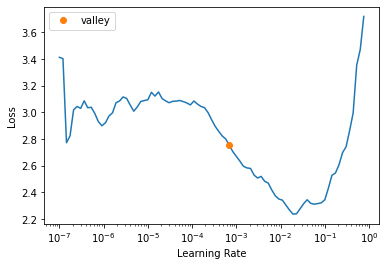

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.871549,0.566812,0.747436,0.674503,0.956410,0.791092,0.923912,01:15


Better model found at epoch 0 with f1_score value: 0.7910922587486745.


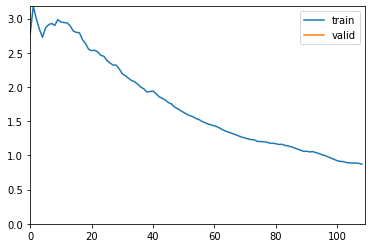

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.215606,0.168087,0.860256,0.948882,0.761538,0.844950,0.950743,01:15
1,0.146235,0.086084,0.897436,0.895408,0.900000,0.897698,0.956394,01:14
2,0.109178,0.124905,0.878205,0.945619,0.802564,0.868239,0.960181,01:16
3,0.088470,0.209527,0.720513,0.643333,0.989744,0.779798,0.961312,01:15
4,0.095734,0.146875,0.847436,0.968858,0.717949,0.824742,0.962433,01:16
5,0.086523,0.116999,0.874359,0.947853,0.792308,0.863128,0.960115,01:15
6,0.075971,0.130204,0.853846,0.792373,0.958974,0.867749,0.951082,01:16


Better model found at epoch 0 with f1_score value: 0.844950213371266.


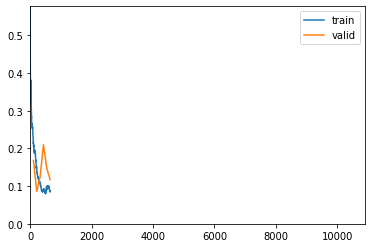

Better model found at epoch 1 with f1_score value: 0.8976982097186701.
No improvement since epoch 1: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9527873767258382.


(#6) [0.09421401470899582,0.8917948603630066,0.8843058350100603,0.9015384615384615,0.8928390045708482,0.9527873767258382]

# 384

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnet_b3_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('efficientnet_b3',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [11]:
learn.load('efficientnet_b3_244')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=9.120108734350652e-05)

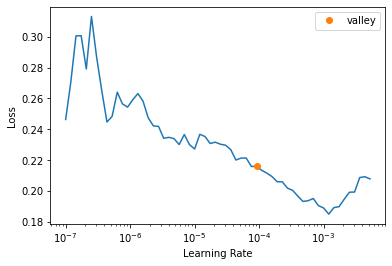

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.118616,0.084241,0.888462,0.946903,0.823077,0.880658,0.965033,01:50


Better model found at epoch 0 with f1_score value: 0.8806584362139918.


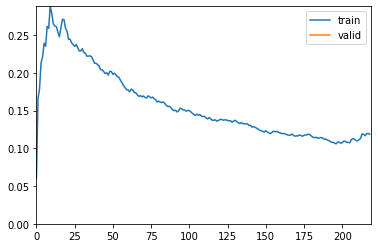

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.088562,0.069997,0.900000,0.938202,0.856410,0.895442,0.966515,01:49
1,0.090026,0.066784,0.902564,0.926630,0.874359,0.899736,0.967140,01:51
2,0.081825,0.073836,0.893590,0.950147,0.830769,0.886457,0.967702,01:52
3,0.082751,0.065211,0.905128,0.931694,0.874359,0.902116,0.968228,01:52
4,0.082823,0.064388,0.906410,0.934247,0.874359,0.903311,0.967242,01:52
5,0.082295,0.065436,0.903846,0.946176,0.856410,0.899058,0.969467,01:52
6,0.074545,0.072273,0.893590,0.952802,0.828205,0.886145,0.969487,01:52
7,0.073589,0.067243,0.905128,0.943820,0.861538,0.900804,0.969359,01:52
8,0.073425,0.065017,0.906410,0.941504,0.866667,0.902537,0.968606,01:52
9,0.066182,0.075814,0.898718,0.956012,0.835897,0.891929,0.969126,01:51


Better model found at epoch 0 with f1_score value: 0.8954423592493297.


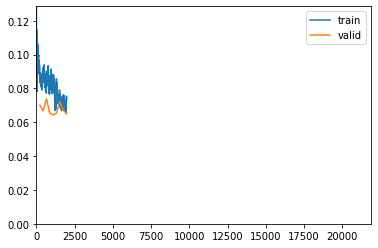

Better model found at epoch 1 with f1_score value: 0.899736147757256.
Better model found at epoch 3 with f1_score value: 0.9021164021164021.
Better model found at epoch 4 with f1_score value: 0.9033112582781457.
No improvement since epoch 4: early stopping


In [14]:
learn.fine_tune(100,base_lr=1e-4)

In [15]:
dfTest = pd.read_csv('../testSample.csv')

In [16]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [17]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [18]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [19]:
learn.dls = dlsTest

In [20]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9571271531886917.


(#6) [0.07974172383546829,0.8948717713356018,0.8993775933609959,0.8892307692307693,0.8942753996905622,0.9571271531886917]

# 512

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnet_b3_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('efficientnet_b3',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('efficientnet_b3_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=3.0199516913853586e-05)

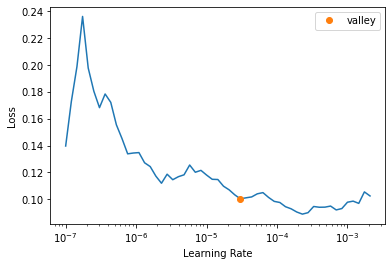

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.199571,0.108646,0.858974,0.934783,0.771795,0.845506,0.951427,03:58


Better model found at epoch 0 with f1_score value: 0.8455056179775281.


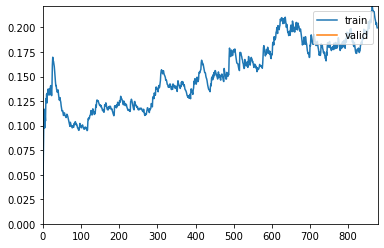

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.089521,0.067549,0.905128,0.934066,0.871795,0.901857,0.967600,03:58
1,0.080410,0.079909,0.887179,0.952096,0.815385,0.878453,0.969675,03:58
2,0.072924,0.062026,0.906410,0.895262,0.920513,0.907712,0.969638,03:55
3,0.072568,0.062445,0.901282,0.935933,0.861538,0.897196,0.969691,03:54
4,0.064690,0.060072,0.915385,0.919689,0.910256,0.914948,0.969602,03:55
5,0.057261,0.068115,0.908974,0.886199,0.938462,0.911582,0.968369,03:52
6,0.059261,0.065391,0.907692,0.914062,0.900000,0.906977,0.970799,03:49
7,0.047991,0.070668,0.892308,0.929775,0.848718,0.887399,0.972242,03:50
8,0.050125,0.064377,0.897436,0.923497,0.866667,0.894180,0.971443,03:49
9,0.046403,0.072027,0.902564,0.931319,0.869231,0.899204,0.968810,03:49


Better model found at epoch 0 with f1_score value: 0.9018567639257294.


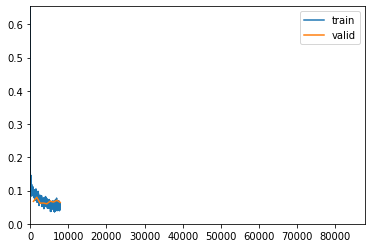

Better model found at epoch 2 with f1_score value: 0.9077117572692793.
Better model found at epoch 4 with f1_score value: 0.9149484536082474.
No improvement since epoch 4: early stopping


In [12]:
learn.fine_tune(100,base_lr=4e-4)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9656052596975673.


(#6) [0.06549865007400513,0.908717930316925,0.9190325972660357,0.8964102564102564,0.9075804776739356,0.9656052596975673]